## Mod DOE
Scratch notebook for testing Ax and pyDOE modules

In [2]:
# !pip install ax-platform
# !pip install pyDOE

In [3]:
import pyDOE
import sys

from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.utils.measurement.synthetic_functions import hartmann6
from ax.utils.notebook.plotting import init_notebook_plotting, render
import plotly.io as pio


import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import scienceplots

import os

import numpy as np

In [4]:
dict_today = pickle.load(open('test_dict.pkl', 'rb'))

In [5]:
for key in dict_today.keys():
    print(key)
    length = len(dict_today[key])
    print(length)
    print(dict_today[key][length-1].shape)

test1
2
(375, 3)
test2
3
(214, 3)


In [6]:
key = dict_today.keys()
key = list(key)[0]

this_entry = dict_today[key]

concatted_entry = np.concatenate(this_entry, axis=0)

print(concatted_entry.shape)
# take max over 2nd column
# max_val = np.max(concatted_entry[:,2])


max = (np.max([float(i) for i in concatted_entry[:,1]])-1023)/1023
print(f'percent torque: {max:.3f}')

(500, 3)
percent torque: 0.397


In [7]:
force_dict = pickle.load(open('3_12_force_dict.pkl', 'rb'))
keys = list(force_dict.keys())
len(force_dict[keys[-1]])


15

In [12]:
force_entry = force_dict[keys[-1]]
# n = 3
# force_entry = [force_entry[0], force_entry[2], force_entry[3]]

In [9]:
# force_dict[keys[-1]] = force_entry
# len(force_dict[keys[-1]])

In [10]:
# pickle.dump(force_dict, open('3_12_force_dict.pkl', 'wb'))

Text(0.5, 1.0, 'Force vs time')

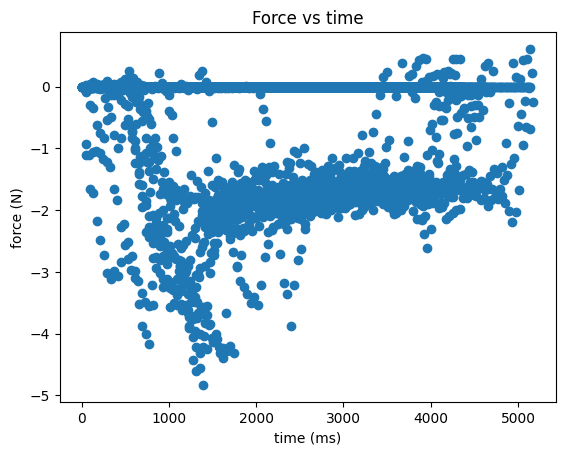

In [13]:
# force_entry = force_dict[keys[-1]]
force_entry = np.concatenate(force_entry, axis=0)

plt.scatter(force_entry[:,0], force_entry[:,1])
plt.xlabel('time (ms)')
plt.ylabel('force (N)')
plt.title('Force vs time')

In [15]:
g = 9.81

for i in range(len(keys)):
    key = keys[i]
    print(f'Mass: {key}')
    mins = []
    for j in range(len(force_dict[key])):
        mins.append(np.min(force_dict[key][j]))
    static_force = np.median(mins)
    print(f'Min force: {static_force:.3f}N')
    mu = -static_force/(float(key[:4])*g)
    print(f'Mu: {mu:.3f}')

Mass: 1.25kg_PLA_NonLubricated
Min force: -2.360N
Mu: 0.192
Mass: 2.35kg_PLA_NonLubricated
Min force: -3.870N
Mu: 0.168


In [16]:
# setup run on nvidia gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Testing Ax on a simple tutorial case
https://ax.dev/docs/tutorials/gpei_hartmann_service

In [17]:
ax_client = AxClient()

[INFO 04-03 12:27:02] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


In [18]:
ax_client.create_experiment(
    name="hartmann_test_experiment",
    parameters=[
        {
            "name": "x1",
            "type": "range",
            "bounds": [0.0, 1.0],
            "value_type": "float",  # Optional, defaults to inference from type of "bounds".
            "log_scale": False,  # Optional, defaults to False.
        },
        {
            "name": "x2",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "x3",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "x4",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "x5",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "x6",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
    ],
    objectives={"hartmann6": ObjectiveProperties(minimize=True)},
    parameter_constraints=["x1 + x2 <= 2.0"],  # Optional.
    outcome_constraints=["l2norm <= 1.25"],  # Optional.
)

[INFO 04-03 12:27:02] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x2. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-03 12:27:02] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x3. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-03 12:27:02] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x4. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-03 12:27:02] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x5. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04

In [19]:
def evaluate(parameterization):
    x = np.array([parameterization.get(f"x{i+1}") for i in range(6)])
    # In our case, standard error is 0, since we are computing a synthetic function.
    return {"hartmann6": (hartmann6(x), 0.0), "l2norm": (np.sqrt((x**2).sum()), 0.0)}

In [29]:
for i in range(13):
    parameterization, trial_index = ax_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameterization))

c:\Users\campb\AppData\Local\Programs\Python\Python311\Lib\site-packages\ax\modelbridge\cross_validation.py:439: UserWarning:

Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.

[INFO 04-03 12:28:26] ax.service.ax_client: Generated new trial 6 with parameters {'x1': 0.567649, 'x2': 0.789829, 'x3': 0.972455, 'x4': 0.586085, 'x5': 0.918558, 'x6': 0.243283} using model Sobol.
[INFO 04-03 12:28:26] ax.service.ax_client: Completed trial 6 with data: {'hartmann6': (-0.986251, 0.0), 'l2norm': (1.771483, 0.0)}.
c:\Users\campb\AppData\Local\Programs\Python\Python311\Lib\site-packages\ax\modelbridge\cross_validation.py:439: UserWarning:

Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.

[INFO 04-03 12:28:26] ax.service.ax_client: Generated new trial 7 with parameters {'x1': 0.345214, 'x2': 0.255329, 'x3': 0.288006, 'x4': 0.154651, 'x5': 0.046876, 'x6': 0.65826} using model Sobol.
[INFO 04-03 12

c:\Users\campb\AppData\Local\Programs\Python\Python311\Lib\site-packages\ax\modelbridge\cross_validation.py:439: UserWarning:

Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.

[INFO 04-03 12:28:27] ax.service.ax_client: Generated new trial 8 with parameters {'x1': 0.297045, 'x2': 0.636371, 'x3': 0.934364, 'x4': 0.456902, 'x5': 0.773334, 'x6': 0.622787} using model Sobol.
[INFO 04-03 12:28:27] ax.service.ax_client: Completed trial 8 with data: {'hartmann6': (-0.043487, 0.0), 'l2norm': (1.600284, 0.0)}.
c:\Users\campb\AppData\Local\Programs\Python\Python311\Lib\site-packages\ax\modelbridge\cross_validation.py:439: UserWarning:

Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.

[INFO 04-03 12:28:27] ax.service.ax_client: Generated new trial 9 with parameters {'x1': 0.519619, 'x2': 0.162205, 'x3': 0.369056, 'x4': 0.771134, 'x5': 0.136226, 'x6': 0.037759} using model Sobol.
[INFO 04-03 1

In [30]:
ax_client.generation_strategy.trials_as_df

C:\Users\campb\AppData\Local\Temp\ipykernel_12572\1060711394.py:1: DeprecationWarning:

`GenerationStrategy.trials_as_df` is deprecated and will be removed in a future release. Please use `Experiment.to_df()` instead.



,trial_index,arm_name,trial_status,generation_method,generation_node,l2norm,hartmann6,x1,x2,x3,x4,x5,x6
0,0,0_0,COMPLETED,Sobol,GenerationStep_0,1.393846,-0.081554,0.375449,0.936570,4.297599e-02,8.906835e-02,1.944894e-01,0.936522
1,1,1_0,COMPLETED,Sobol,GenerationStep_0,1.574042,-0.018308,0.660461,0.393251,7.276685e-01,6.536209e-01,8.395477e-01,0.474542
2,2,2_0,COMPLETED,Sobol,GenerationStep_0,1.333540,-0.117032,0.792156,0.738388,3.758738e-01,3.329382e-01,5.897601e-01,0.075196
3,3,3_0,COMPLETED,Sobol,GenerationStep_0,1.407938,-0.053608,0.014712,0.212525,8.181347e-01,8.931569e-01,4.447643e-01,0.521553
4,4,4_0,COMPLETED,Sobol,GenerationStep_0,1.452606,-0.179108,0.232524,0.597506,5.773312e-01,8.359371e-01,2.972118e-01,0.760622
5,5,5_0,COMPLETED,Sobol,GenerationStep_0,1.277272,-0.022879,0.947390,0.076556,1.348262e-01,3.921111e-01,6.687090e-01,0.330022
6,6,6_0,COMPLETED,Sobol,GenerationStep_0,1.771483,-0.986251,0.567649,0.789829,9.724545e-01,5.860847e-01,9.185577e-01,0.243283
7,7,7_0,COMPLETED,Sobol,GenerationStep_0,0.852487,-0.802139,0.345214,0.255329,2.880061e-01,1.546514e-01,4.687590e-02,0.658260
8,8,8_0,COMPLETED,Sobol,GenerationStep_0,1.600284,-0.043487,0.297045,0.636371,9.343639e-01,4.569023e-01,7.733342e-01,0.622787
9,9,9_0,COMPLETED,Sobol,GenerationStep_0,1.023303,-0.033584,0.519619,0.162205,3.690564e-01,7.711344e-01,1.362255e-01,0.037759


In [31]:
best_parameters, values = ax_client.get_best_parameters()
best_parameters

{'x1': 0.39713088779852374,
 'x2': 0.7392100677967107,
 'x3': 0.11057115887965312,
 'x4': 0.5815077596271636,
 'x5': 0.6061295403893022,
 'x6': 0.2012325372375405}

In [32]:
render(ax_client.get_contour_plot())

[INFO 04-03 12:36:38] ax.service.ax_client: Retrieving contour plot with parameter 'x1' on X-axis and 'x2' on Y-axis, for metric 'hartmann6'. Remaining parameters are affixed to the middle of their range.


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
render(ax_client.get_contour_plot(param_x="x3", param_y="x4", metric_name="l2norm"))

[INFO 02-28 12:27:25] ax.service.ax_client: Retrieving contour plot with parameter 'x3' on X-axis and 'x4' on Y-axis, for metric 'l2norm'. Remaining parameters are affixed to the middle of their range.


In [ ]:
render(
    ax_client.get_optimization_trace(objective_optimum=hartmann6.fmin)
)  # Objective_optimum is optional.

In [ ]:
print(trial_index)

24


In [ ]:
# optional save/load code
# file_name = "hartmann_test_experiment.json"
# ax_client.save_to_json_file(filepath=file_name)
# restored_ax_client = (
#     AxClient.load_from_json_file(filepath=file_name)
# )  # For custom filepath, pass `filepath` argument.

# Inputting personal dataset for optimization
Using data from height optimization

In [ ]:
# what is the datatype for the ax_client trial data?
print(type(ax_client.generation_strategy.trials_as_df))

<class 'pandas.core.frame.DataFrame'>


C:\Users\Greg\AppData\Local\Temp\ipykernel_29832\256097959.py:2: DeprecationWarning:

`GenerationStrategy.trials_as_df` is deprecated and will be removed in a future release. Please use `Experiment.to_df()` instead.



In [ ]:
# let's set up our experiment
SPA_ax_client = AxClient()
SPA_ax_client.create_experiment(
    name="SPA_max_height_experiment",
    parameters=[
        {
            "name": "thickness",
            "type": "range",
            "bounds": [2.0, 3.0],
            "value_type": "float",  # Optional, defaults to inference from type of "bounds".
            "log_scale": False,  # Optional, defaults to False.
        },
        {
            "name": "contact", #radius
            "type": "range",
            "bounds": [25.4, 38.1],
        },
        {
            "name": "ring1",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "ring2",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "ring3",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "ring4",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
    ],
    objectives={"cost": ObjectiveProperties(minimize=True)},
    parameter_constraints=["ring1 <= ring2","ring2 <= ring3","ring3 <= ring4"],
    # outcome_constraints=["l2norm <= 1.25"],  # Optional.
)

[INFO 02-28 12:27:25] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 02-28 12:27:25] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter contact. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-28 12:27:25] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter ring1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-28 12:27:25] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter ring2. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-28 12:27:25] 

In [ ]:
# import test data
test_name = 'SPA_test_data_dictionary_N_Pa.pkl'
test_data = pickle.load(open(test_name, 'rb'))


In [ ]:
h_scale = 80 #mm
f_scale = 100 #N
p_scale = 10000 #Pa

ks = [500, 500, 1] # cost function weights

# target points - len 'num_targets'
target_Fs = np.array([24.5, 24.5, 24.5])
target_Ps = np.array([4137, 5516, 6895])
# target_h = Max

# calc cost for each test - can be used on vectors. 
# F_err/P_err/h_scaled should be scaled values
# Should use a single targ_F/P
def error_cost_fn(ks, F_err, P_err, h_scaled):
    k_f, k_p, k_h = ks
    cost = k_f*F_err + k_p*P_err - k_h*h_scaled
    return cost


In [ ]:
# ring data reverse solver (scale 0-1)
_radius = 70 #mm
_min_spacing = 3 #mm
_min_width = 5 #mm


# Go between scaled ring_params (num_rings,2) and raw rw (num_rings,2)

def get_rw(w0, ring_params, num_rings, radius=_radius, min_spacing=_min_spacing, min_width=_min_width, max_rings=2):
    ring_params = np.sort(ring_params) # sorts entries from smallest to largest
    available_space = radius - w0 - min_spacing*(num_rings+1) - 2*min_width*num_rings
    #assert (available_space>0), "There is no space available for rings!"
    radii = [w0 + (i+1)*min_spacing + (2*i+1)*min_width +  available_space*(ring_params[2*i+1]+ring_params[2*i])/2 for i in range(num_rings)]
    widths = [min_width + available_space*(ring_params[2*i+1]-ring_params[2*i])/2 for i in range(num_rings)]
    radii = np.array(radii + (max_rings-num_rings)*[np.nan])
    widths = np.array(widths + (max_rings-num_rings)*[np.nan])
    return np.ravel(np.vstack([radii, widths]), order='F')

def reverse_get_rw(rw, w0, num_rings, radius=_radius, min_spacing=_min_spacing, min_width=_min_width, max_rings=2):
    # Reshape the input array to separate radii and widths
    rw = np.reshape(rw, (2, max_rings), order='F')
    radii = rw[0, :num_rings]
    widths = rw[1, :num_rings]
    # print(f'radii: {radii}, widths: {widths}')
    
    # Calculate available space
    available_space = radius - w0 - min_spacing * (num_rings + 1) - 2 * min_width * num_rings
    
    # Reverse the calculation of ring_params
    ring_params = []
    for i in range(num_rings):
        # ring_param1 = (2 * (radii[i] - w0 - (i + 1) * min_spacing - (2 * i + 1) * min_width) / available_space) - widths[i]
        # ring_param2 = (2 * widths[i] / available_space) + ring_param1
        ring_param1 = (radii[i] - w0 - (i + 1) * min_spacing - (2 * i ) * min_width - widths[i]) / available_space
        ring_param2 = ring_param1 + 2*(widths[i] - min_width) / available_space
        ring_params.extend([ring_param1, ring_param2])
    
    return np.sort(np.array(ring_params))


In [ ]:
# test error fn
F_err = np.array([0.1,1])
P_err = np.array([0.1,1])
h_scaled = np.array([0.1, 1])
error = error_cost_fn(ks, F_err, P_err, h_scaled)
print(error)

[ 99.9 999. ]


In [ ]:
entry = test_data[list(test_data.keys())[1]]
hs = entry[0][0][:, 0]
ps = entry[0][1]
fs = entry[1]
# print(f'Lens: {len(hs)}, {len(ps)}, {len(fs)}') # should all be the same length - call it num_data
print(f'Membrane: {entry[0][0][0][1::]}')

radius=_radius
min_spacing=_min_spacing
min_width=_min_width
max_rings=2

thickness = float(entry[0][0][0][1])
contact = np.round(float(entry[0][0][0][2]),1)
ring1 = float(entry[0][0][0][3])
ring2 = float(entry[0][0][0][4])
ring3 = float(entry[0][0][0][5])
ring4 = float(entry[0][0][0][6])

rw = np.array([[ring1, ring2,ring3, ring4]])
ring_params = np.array([0.5, 0.3,0.2,0.4])

rw = get_rw(thickness, ring_params, 2)
print(f'rw: {rw}')
back_params = reverse_get_rw(rw, thickness, 2)
print(f'back_params: {back_params}')

Membrane: [ 2.  25.4 33.4  5.  46.4  5. ]
rw: [19.75  6.95 40.55  6.95]
back_params: [0.2 0.3 0.4 0.5]


In [ ]:
# Solve for error values and set up experiments
error_vals = []

for i in range(len(test_data.keys())-1):
    i = i+1 # skip the first entry (no rings - would break this (I assume))
    entry = test_data[list(test_data.keys())[i]]
    hs = entry[0][0][:, 0]
    ps = entry[0][1]
    fs = entry[1]
    # print(f'Lens: {len(hs)}, {len(ps)}, {len(fs)}') # should all be the same length - call it num_data
    print(f'Membrane: {entry[0][0][0][1::]}')

    thickness = float(entry[0][0][0][1])
    contact = np.round(float(entry[0][0][0][2]),1)
    ring1 = float(entry[0][0][0][3])
    ring2 = float(entry[0][0][0][4])
    ring3 = float(entry[0][0][0][5])
    ring4 = float(entry[0][0][0][6])

    rw = np.array([ring1, ring2,ring3, ring4])
    back_params = reverse_get_rw(rw, thickness, 2)
    print(f'back_params: {back_params}')

    force_errors = ((fs - target_Fs)/f_scale)**2 # shape (num_data, num_targets)
    pressure_errors = ((ps - target_Ps)/p_scale)**2 # shape (num_data, num_targets)
    height_factors = (hs/h_scale) # shape (num_targets,)
    # print(f'Shapes: {force_errors.shape}, {pressure_errors.shape}, {height_factors.shape}')

    error_cost = 0
    # add cost for each target
    for j in range(len(target_Fs)):
        error_cost += np.min(error_cost_fn(ks, force_errors[:, j], pressure_errors[:, j], height_factors[j]))
    print(f'cost: {error_cost:.5f}')
    error_vals.append(error_cost)
    SPA_ax_client.attach_trial(
        parameters={"thickness": thickness, "contact": contact, "ring1": back_params[0], "ring2": back_params[1], "ring3": back_params[2], "ring4": back_params[3]}
    )
    print(f'Attached trial {i-1}')
    SPA_ax_client.complete_trial(trial_index=i-1, raw_data=float(error_cost))

[INFO 02-28 12:27:25] ax.core.experiment: Attached custom parameterizations [{'thickness': 2.0, 'contact': 25.4, 'ring1': 0.6, 'ring2': 0.6, 'ring3': 0.6, 'ring4': 0.6}] as trial 0.
[INFO 02-28 12:27:25] ax.service.ax_client: Completed trial 0 with data: {'cost': (-0.037391, None)}.
[INFO 02-28 12:27:25] ax.core.experiment: Attached custom parameterizations [{'thickness': 2.33, 'contact': 29.6, 'ring1': 0.705974, 'ring2': 0.705974, 'ring3': 1.0, 'ring4': 1.0}] as trial 1.
[INFO 02-28 12:27:25] ax.service.ax_client: Completed trial 1 with data: {'cost': (0.000106, None)}.
[INFO 02-28 12:27:25] ax.core.experiment: Attached custom parameterizations [{'thickness': 2.0, 'contact': 28.0, 'ring1': 0.912308, 'ring2': 0.912308, 'ring3': 0.912308, 'ring4': 1.0}] as trial 2.
[INFO 02-28 12:27:25] ax.service.ax_client: Completed trial 2 with data: {'cost': (0.000149, None)}.
[INFO 02-28 12:27:25] ax.core.experiment: Attached custom parameterizations [{'thickness': 2.0, 'contact': 25.4, 'ring1': 1.

Membrane: [ 2.  25.4 33.4  5.  46.4  5. ]
back_params: [0.60000004 0.60000004 0.60000004 0.60000004]
cost: -0.03739
Attached trial 0
Membrane: [ 2.33 29.63 37.63  5.   62.    5.  ]
back_params: [0.70597365 0.70597365 1.         1.        ]
cost: 0.00011
Attached trial 1
Membrane: [ 2.   27.98 45.58  5.   60.29  6.71]
back_params: [0.91230771 0.91230774 0.91230774 1.00000002]
cost: 0.00015
Attached trial 2
Membrane: [ 2.  25.4 49.   5.  62.   5. ]
back_params: [1. 1. 1. 1.]
cost: -0.03737
Attached trial 3
Membrane: [ 2.   38.1  47.55  6.45 62.    5.  ]
back_params: [0.92564101 0.99999998 1.         1.        ]
cost: 0.00011
Attached trial 4
Membrane: [ 2.   31.92 46.    5.   59.    5.  ]
back_params: [0.92307692 0.92307692 0.92307692 0.92307692]
cost: 0.00011


[INFO 02-28 12:27:25] ax.core.experiment: Attached custom parameterizations [{'thickness': 2.0, 'contact': 31.9, 'ring1': 0.923077, 'ring2': 0.923077, 'ring3': 0.923077, 'ring4': 0.923077}] as trial 5.
[INFO 02-28 12:27:25] ax.service.ax_client: Completed trial 5 with data: {'cost': (0.000111, None)}.


Attached trial 5


In [ ]:
len(SPA_ax_client.generation_strategy.trials_as_df)

C:\Users\Greg\AppData\Local\Temp\ipykernel_29832\646970639.py:1: DeprecationWarning:

`GenerationStrategy.trials_as_df` is deprecated and will be removed in a future release. Please use `Experiment.to_df()` instead.



6

In [ ]:
SPA_ax_client.generation_strategy.trials_as_df

C:\Users\Greg\AppData\Local\Temp\ipykernel_29832\1387325123.py:1: DeprecationWarning:

`GenerationStrategy.trials_as_df` is deprecated and will be removed in a future release. Please use `Experiment.to_df()` instead.



,trial_index,arm_name,trial_status,cost,thickness,contact,ring1,ring2,ring3,ring4
0,0,0_0,COMPLETED,-0.037391,2.00,25.4,0.600000,0.600000,0.600000,0.600000
1,1,1_0,COMPLETED,0.000106,2.33,29.6,0.705974,0.705974,1.000000,1.000000
2,2,2_0,COMPLETED,0.000149,2.00,28.0,0.912308,0.912308,0.912308,1.000000
3,3,3_0,COMPLETED,-0.037367,2.00,25.4,1.000000,1.000000,1.000000,1.000000
4,4,4_0,COMPLETED,0.000107,2.00,38.1,0.925641,1.000000,1.000000,1.000000
5,5,5_0,COMPLETED,0.000111,2.00,31.9,0.923077,0.923077,0.923077,0.923077


In [ ]:
# define function to take parameters and return params (not rw)
# w0, ring_params, num_rings
def get_params(params):
    w0 = params.get('contact')
    ring1 = params.get('ring1')
    ring2 = params.get('ring2')
    ring3 = params.get('ring3')
    ring4 = params.get('ring4')
    rw = get_rw(w0, np.array([ring1, ring2, ring3, ring4]), 2)
    return rw

In [ ]:
best_parameters, values = SPA_ax_client.get_best_parameters()
print(best_parameters)
print(get_params(best_parameters))

{'thickness': 2.0, 'contact': 25.4, 'ring1': 0.6000000391251001, 'ring2': 0.6000000391251001, 'ring3': 0.6000000391251001, 'ring4': 0.6000000391251001}
[42.76000061  5.         55.76000061  5.        ]


In [ ]:
# check next trial
parameterization, trial_index = SPA_ax_client.get_next_trial()
print(parameterization)
print(get_params(parameterization))

c:\Users\Greg\Python\.venv\Lib\site-packages\ax\modelbridge\cross_validation.py:439: UserWarning:

Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.

[INFO 02-28 12:27:25] ax.service.ax_client: Generated new trial 6 with parameters {'thickness': 2.208479, 'contact': 30.034811, 'ring1': 0.272853, 'ring2': 0.443837, 'ring3': 0.499228, 'ring4': 0.516321} using model Sobol.


{'thickness': 2.208478997461498, 'contact': 30.034810643363745, 'ring1': 0.2728525837883353, 'ring2': 0.4438370745629072, 'ring3': 0.49922808539122343, 'ring4': 0.5163208851590753}
[41.96412955  5.93743866 56.60265402  5.09371289]


In [ ]:
render(SPA_ax_client.get_contour_plot(param_x="thickness", param_y="contact", metric_name="cost"))

[INFO 02-28 12:27:48] ax.service.ax_client: Retrieving contour plot with parameter 'thickness' on X-axis and 'contact' on Y-axis, for metric 'cost'. Remaining parameters are affixed to the middle of their range.
[INFO 02-28 12:27:48] ax.service.ax_client: Model RandomModelBridge(model=SobolGenerator) does not implement `predict`, so it cannot be used to generate a response surface plot.


UnsupportedPlotError: Could not obtain contour plot of "cost" for parameters "thickness" and "contact", as a model with predictive ability, such as a Gaussian Process, has not yet been trained in the course of this optimization.

## PyDOE for Taguchi generation
Try to apply as forward-looking for upcoming OA. pyDOE doesn't seem to have built-in function for fractional factorials. May need to hand-implement via something like https://www.york.ac.uk/depts/maths/tables/orthogonal.htm

In [ ]:
# use pyDOE to generate a Taguchi L32 array
num_params = 10
t_array = pyDOE.orthogonal(num_params, 2)

AttributeError: module 'pyDOE' has no attribute 'orthogonal'

# BayzOp for Taguchi array optimization

In [ ]:
Tag_client = AxClient()

In [ ]:
'''
Function 'score vals'
takes:  in_vals (parameters to sweep) [8,n]
        target_z_r1 - target gears for ring 1 ()
gives: score [scalar] - number of valid combinations
NOTE - for scores to be transferable, give the same size vectors across different in_vals

'''

def score_vals(in_vals, target_z_r1 = 90):

    # Calculate all possible combinations of gear ratios
    z_s, z_p2, z_r2 = np.meshgrid(
        *in_vals[:3], indexing='ij'
    )

    z_r1 = target_z_r1
    z_p1 = (z_r1 - z_s)/2
    non_integers = z_p1[np.mod(z_p1, 1) != 0]
    if len(non_integers) > 0:
        print('Invalid z_s values (not divisble by 2)')
        return

    I1 = z_r1 / z_s
    I2 = (z_r1 * z_p2) / (z_p1 * z_r2)
    gr_s = (1 - I2) / (1 + I1)
    ratios = 1 / gr_s

    # only keep valid combinations (ratios w.in tolerance)
    valid_combinations = np.logical_and(gr_s > 0, np.abs(TARGET_GEAR_RATIO - ratios) <= RATIO_TOLERANCE)
    filt_z_s = np.unique(z_s[valid_combinations])
    filt_z_p2 = np.unique(z_p2[valid_combinations])
    filt_z_r2 = np.unique(z_r2[valid_combinations])

    z_s, z_p2, z_r2, xs, xp1, xp2, xr2 = np.meshgrid(
        filt_z_s, filt_z_p2, filt_z_r2, *in_vals[3:], indexing='ij'
    )

    # flatten
    z_s = z_s.flatten()
    z_p2 = z_p2.flatten()
    z_r2 = z_r2.flatten()
    xs = xs.flatten()
    xp1 = xp1.flatten()
    xp2 = xp2.flatten()
    xr2 = xr2.flatten()

    z_p1 = (z_r1 - z_s)/2

    I1 = z_r1 / z_s
    I2 = (z_r1 * z_p2) / (z_p1 * z_r2)
    gr_s = (1 - I2) / (1 + I1)
    ratios = 1 / gr_s

    total_combinations = z_s.size

    valid_combinations = np.logical_and(np.logical_and(gr_s > 0, np.abs(TARGET_GEAR_RATIO - ratios) <= RATIO_TOLERANCE), z_s + 2 * z_p1 == z_r1)

    # z_r1 = z_r1[valid_combinations]
    z_s, z_p1, z_p2, z_r2, xs, xp1, xp2, xr2 = z_s[valid_combinations], z_p1[valid_combinations], z_p2[valid_combinations], z_r2[valid_combinations], xs[valid_combinations], xp1[valid_combinations], xp2[valid_combinations], xr2[valid_combinations]
    I1, I2, gr_s, ratios = I1[valid_combinations], I2[valid_combinations], gr_s[valid_combinations], ratios[valid_combinations]

    assert z_s.shape == z_p1.shape == z_p2.shape == z_r2.shape == xs.shape == xp1.shape == xp2.shape == xr2.shape == ratios.shape

    ra = (z_s * MODULE + z_p1 * MODULE) / 2.0

    # Basic circle diameters
    db_a1 = MODULE * z_s * np.cos(ALPHA)
    db_a2 = MODULE * z_p1 * np.cos(ALPHA)
    db_b1 = MODULE * z_p1 * np.cos(ALPHA)
    db_b2 = MODULE * target_z_r1 * np.cos(ALPHA)
    db_c1 = MC * z_p2 * np.cos(ALPHA)
    db_c2 = MC * z_r2 * np.cos(ALPHA)

    # Working pressure angles (modified formula)
    alpha_wa = np.arccos(MODULE * (z_s + z_p1) * np.cos(ALPHA) / (2 * ra))
    alpha_wb = np.arccos(MODULE * (-z_p1 + target_z_r1) * np.cos(ALPHA) / (2 * ra)) # why is this constant??
    val = MC * (-z_p2 + z_r2) * np.cos(ALPHA) / (2 * ra)
    alpha_wc = np.arccos(np.clip(val, -1, 1))
    # Center distance modification coefficient
    ya = ((z_s + z_p1) / 2.0) * ((np.cos(ALPHA) / np.cos(alpha_wa)) - 1)
    # Tip circle diameters
    das  = MODULE * z_s + 2 * MODULE * (1 + ya - xp1)
    dap1 = MODULE * z_p1 + 2 * MODULE * (1 + np.minimum(ya - xs, xp1))
    dar1 = MODULE * target_z_r1 - 2 * MODULE * (1 - XR1)
    dap2 = MC * z_p2 + 2 * MC * (1 + xp2)
    dar2 = MC * z_r2 - 2 * MC * (1 - xr2)
    # Tip pressure angles
    alpha_aa1 = np.arccos(db_a1 / das)
    alpha_aa2 = np.arccos(db_a2 / dap1)
    alpha_ab1 = np.arccos(db_b1 / dap1)
    alpha_ab2 = np.arccos(db_b2 / dar1)
    alpha_ac1 = np.arccos(db_c1 / dap2)
    val2 = db_c2 / dar2
    alpha_ac2 = np.arccos(np.clip(val2, -1, 1))
    # Approach and recess contact ratios
    ea1 = (z_p1 / (2 * np.pi)) * (np.tan(alpha_aa2) - np.tan(alpha_wa))
    ea2 = (z_s / (2 * np.pi)) * (np.tan(alpha_aa1) - np.tan(alpha_wa))
    eb1 = -(target_z_r1 / (2 * np.pi)) * (np.tan(alpha_ab2) - np.tan(alpha_wb))
    eb2 = (z_p1 / (2 * np.pi)) * (np.tan(alpha_ab1) - np.tan(alpha_wb))
    ec1 = -(z_r2 / (2 * np.pi)) * (np.tan(alpha_ac2) - np.tan(alpha_wc))
    ec2 = (z_p2 / (2 * np.pi)) * (np.tan(alpha_ac1) - np.tan(alpha_wc))
    ea = ea1**2 + ea2**2 - ea1 - ea2 + 1
    eb = eb1**2 + eb2**2 - eb1 - eb2 + 1
    ec = ec1**2 + ec2**2 - ec1 - ec2 + 1
    # Basic driving efficiencies
    Ea_val = 1 - MU* np.pi * (1 / z_s + 1 / z_p1) * ea
    Eb_val = 1 - MU* np.pi * (1 / z_p1 - 1 / target_z_r1) * eb
    Ec_val = 1 - MU* np.pi * (1 / z_p2 - 1 / z_r2) * ec
    # Forward driving efficiency 
    eta_fwd = (1 + Ea_val * Eb_val * I1) * (1 - I2) / ((1 + I1) * (1 - Eb_val * Ec_val * I2))
    # Backward driving efficiency
    def eta_bwd1(I1, I2, Ea_val, Eb_val, Ec_val):
        return (1 + I1) * Ea_val * (Eb_val * Ec_val - I2) / (Ec_val * (Ea_val * Eb_val + I1) * (1 - I2))
    def eta_bwd2(I1, I2, Ea_val, Eb_val, Ec_val):
        return (1 + I1)*Ea_val*(1-Eb_val*Ec_val*I2)/((Ea_val+Eb_val*I1)*(1-I2))
    eta_bwd = np.where(I2 > 1, eta_bwd2(I1, I2, Ea_val, Eb_val, Ec_val), eta_bwd1(I1, I2, Ea_val, Eb_val, Ec_val))
    # eta_bwd = (1 + I1) * Ea_val * (Eb_val * Ec_val - I2) / (Ec_val * (Ea_val * Eb_val + I1) * (1 - I2))

    # filter high eta_bwd
    eta_bwd = np.where(eta_bwd > 1, 0, eta_bwd)
    eta_bwd = np.where(eta_bwd < 0, 0, eta_bwd)

    # Average and std for eta
    avg_fwd = np.mean(eta_fwd)
    std_fwd = np.std(eta_fwd)
    avg_bwd = np.mean(eta_bwd)
    std_bwd = np.std(eta_bwd)

    # view_vector(eta_fwd, 1, "eta_fwd")
    # view_vector(eta_bwd, 1, "eta_bwd")

    composite_score = ratios * eta_fwd * eta_bwd

    bd_indices = np.where(eta_bwd > 0.3)

    score = len(z_s[bd_indices])
    return score